In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import os
import sklearn
import datetime
import seaborn as sns
%matplotlib inline

In [2]:
def read_csv(filepath):
     if os.path.splitext(filepath)[1] != '.csv':
          return  # or whatever
     seps = [',', ';', '\t']                    # ',' is default
     encodings = [None, 'utf-8', 'ISO-8859-1']  # None is default
     for sep in seps:
         for encoding in encodings:
              try:
                  return pd.read_csv(filepath, encoding=encoding, sep=sep)
              except Exception:  # should really be more specific 
                  pass
     raise ValueError("{!r} is has no encoding in {} or seperator in {}"
                      .format(filepath, encodings, seps))

In [3]:
df = read_csv('SCMS_Delivery_History_Dataset_20150929.csv')

# Exploratory Data Analysis

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10324 entries, 0 to 10323
Data columns (total 33 columns):
ID                              10324 non-null int64
Project Code                    10324 non-null object
PQ #                            10324 non-null object
PO / SO #                       10324 non-null object
ASN/DN #                        10324 non-null object
Country                         10324 non-null object
Managed By                      10324 non-null object
Fulfill Via                     10324 non-null object
Vendor INCO Term                10324 non-null object
Shipment Mode                   9964 non-null object
PQ First Sent to Client Date    10324 non-null object
PO Sent to Vendor Date          10324 non-null object
Scheduled Delivery Date         10324 non-null object
Delivered to Client Date        10324 non-null object
Delivery Recorded Date          10324 non-null object
Product Group                   10324 non-null object
Sub Classification           

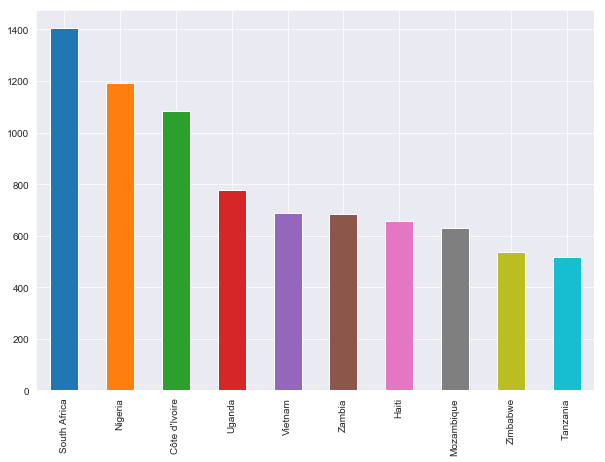

In [5]:
sns.set_style('darkgrid')
country = df['Country'].value_counts().head(10)
fig, ax = plt.subplots(figsize=(10,7))
country.plot.bar(ax=ax)

In [6]:
df['Shipment Mode'].value_counts()

Air            6113
Truck          2830
Air Charter     650
Ocean           371
Name: Shipment Mode, dtype: int64

In [7]:
df['Fulfill Via'].value_counts()

From RDC       5404
Direct Drop    4920
Name: Fulfill Via, dtype: int64

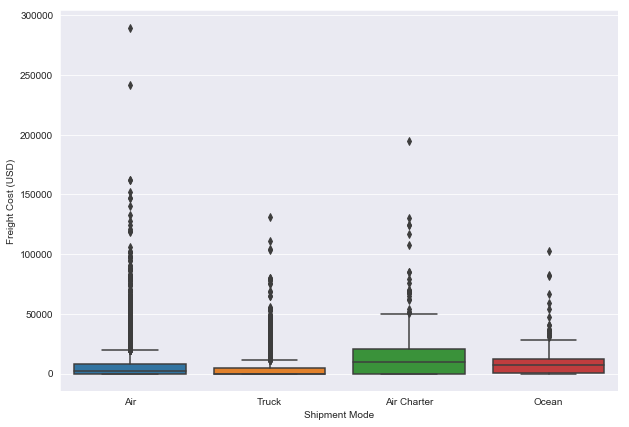

In [29]:
fig, ax = plt.subplots(figsize=(10,7))
sns.boxplot(df['Shipment Mode'],df['Freight Cost (USD)'],ax=ax);

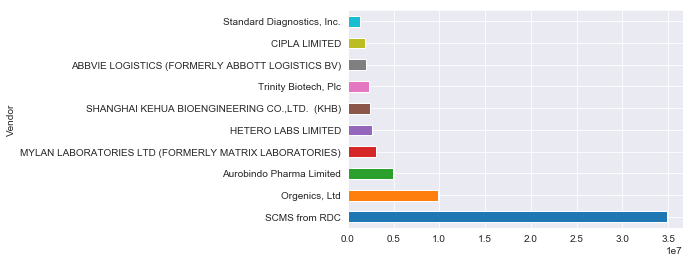

In [30]:
df.groupby('Vendor')['Freight Cost (USD)'].sum().sort_values(ascending=False).head(10).plot.barh();

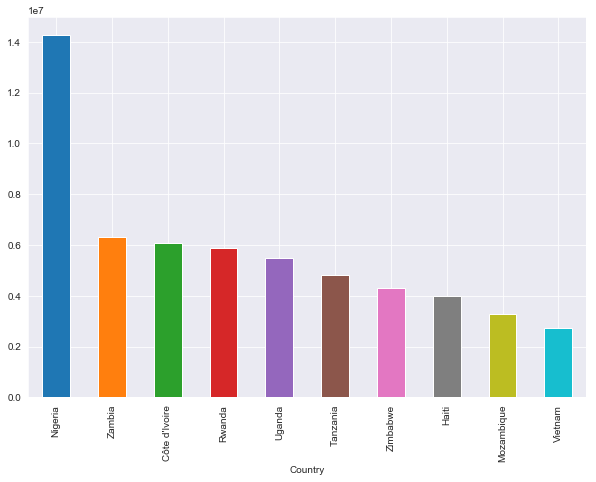

In [31]:
fig, ax = plt.subplots(figsize=(10,7))
df.groupby('Country')['Freight Cost (USD)'].sum().sort_values(ascending=False).head(10).plot.bar(ax=ax);

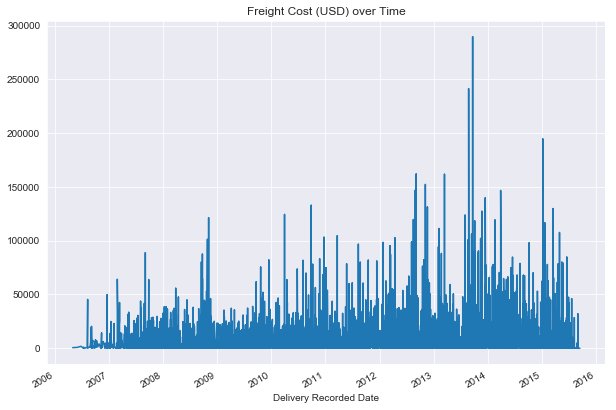

In [32]:
dt = df.set_index('Delivery Recorded Date')['Freight Cost (USD)']
fig, ax = plt.subplots(figsize=(10,7))
dt.plot(title='Freight Cost (USD) over Time');

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


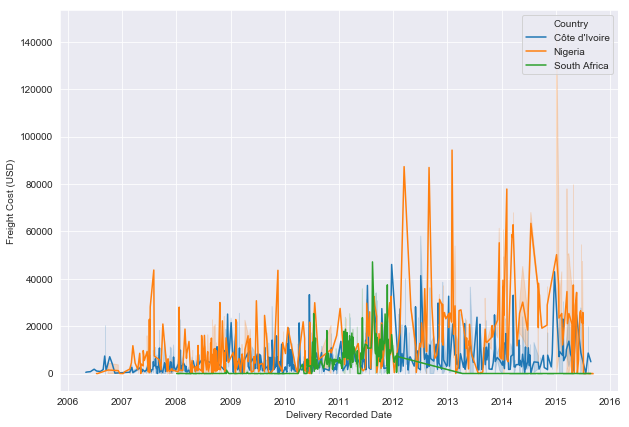

In [33]:
dtc = df[df['Country'].isin(df['Country'].value_counts().head(3).index)]
dtc = dtc.set_index('Delivery Recorded Date')[['Freight Cost (USD)','Country']]
fig, ax = plt.subplots(figsize=(10,7))
sns.lineplot(x='Delivery Recorded Date',y='Freight Cost (USD)',data=dtc.reset_index(),hue='Country')

In [34]:
# Identify number of categorical features
for d in df.columns:
    if(df[d].dtype == 'O'):
        print(d,': ', df[d].nunique())

Project Code :  142
PQ # :  1237
PO / SO # :  6233
ASN/DN # :  7030
Country :  43
Managed By :  4
Fulfill Via :  2
Vendor INCO Term :  8
Shipment Mode :  4
Product Group :  5
Sub Classification :  6
Vendor :  73
Item Description :  184
Molecule/Test Type :  86
Brand :  48
Dosage :  54
Dosage Form :  17
Manufacturing Site :  88
First Line Designation :  2
Delivery Period :  113


# Data Pre-Processing

In [9]:
# Convert Date fields to DateTime data type
df['PQ First Sent to Client Date'] = pd.to_datetime(df[df['PQ First Sent to Client Date']!='NA']\
                                ['PQ First Sent to Client Date'],errors='coerce',format='%m/%d/%Y')

df['PO Sent to Vendor Date'] = pd.to_datetime(df[df['PO Sent to Vendor Date']!='NA']\
                                ['PO Sent to Vendor Date'],errors='coerce',format='%m/%d/%Y')

df['Scheduled Delivery Date'] = pd.to_datetime(df[df['Scheduled Delivery Date']!='NA']\
                                ['Scheduled Delivery Date'],errors='coerce',format='%d-%b-%y')

df['Delivered to Client Date'] = pd.to_datetime(df[df['Delivered to Client Date']!='NA']\
                                ['Delivered to Client Date'],errors='coerce',format='%d-%b-%y')

df['Delivery Recorded Date'] = pd.to_datetime(df['Delivery Recorded Date'],errors='coerce',format='%d-%b-%y')

In [17]:
df['Delivery Period'] = df['Delivery Recorded Date'].copy()
df['Delivery Period'] = df['Delivery Period'].apply(lambda x: x.strftime('%Y%m'))

In [18]:
# Create feature to be predicted by identifying difference between scheduled and actual delivery
df['Schedule v Actual'] = df['Scheduled Delivery Date'] - df['Delivery Recorded Date']
df['Schedule v Actual'].value_counts().head(15)

0 days     5514
-1 days     223
-3 days     133
-2 days     131
17 days     117
7 days      108
-5 days     106
-6 days     101
13 days     100
6 days       99
8 days       97
-4 days      97
2 days       94
-7 days      93
31 days      81
Name: Schedule v Actual, dtype: int64

In [19]:
# Transform Schedule v. Actual column into a categorical int value removing trailing 'days' from values
df['Schedule v Actual'] = (df['Schedule v Actual'] / np.timedelta64(1, 'D')).astype('category')

In [20]:
len(df['Scheduled Delivery Date'])

10324

In [36]:
dt = df.select_dtypes(include='datetime')

for col in dt.columns:
    df[col+' day'] = pd.DatetimeIndex(df[col]).day
    df[col+' month'] = pd.DatetimeIndex(df[col]).month
    df[col+' year'] = pd.DatetimeIndex(df[col]).year
    df.drop(col,axis=1,inplace=True)

In [37]:
# Drop columns w/o relevant info from analysis
df.drop(['ID','PO / SO #','ASN/DN #','PQ #'],axis=1,inplace=True)

In [21]:
df['Weight (Kilograms)'].value_counts().head(15)

Weight Captured Separately    1507
2                               29
6                               26
1                               23
5                               20
60                              20
4                               19
3                               18
39                              17
18                              17
36                              17
12                              17
21                              17
14                              17
17                              17
Name: Weight (Kilograms), dtype: int64

In [22]:
# Set all entries with 'Weight Captured Separately' as Null
df['Weight (Kilograms)'].replace('Weight Captured Separately',0,inplace=True)

In [23]:
# Replace string values with zero
df.loc[df['Weight (Kilograms)'].str.contains('See',na=False), 'Weight (Kilograms)'] = 0

In [24]:
# Update previously transformed zero values with mean value of data
df['Weight (Kilograms)'] = df['Weight (Kilograms)'].astype('int64')
df['Weight (Kilograms)'].replace(0,df[df['Weight (Kilograms)']!=0].mean(),inplace=True)

In [25]:
df['Freight Cost (USD)'].value_counts().head(15)

Freight Included in Commodity Cost    1442
Invoiced Separately                    239
9736.1                                  36
6147.18                                 27
See DN-304 (ID#:10589)                  16
13398.06                                16
7445.8                                  16
9341.49                                 15
See ASN-32231 (ID#:13648)               14
See ASN-31750 (ID#:19272)               14
See ASN-28279 (ID#:13547)               13
7329.83                                 12
See DN-3015 (ID#:82554)                 12
1211.48                                 11
25231.96                                11
Name: Freight Cost (USD), dtype: int64

In [26]:
# Apply same transformations to freight cost feature
df['Freight Cost (USD)'].replace('Freight Included in Commodity Cost',0,inplace=True)
df['Freight Cost (USD)'].replace('Invoiced Separately',0,inplace=True)
df.loc[df['Freight Cost (USD)'].str.contains('See',na=False), 'Freight Cost (USD)'] = 0

In [27]:
df['Freight Cost (USD)'] = df['Freight Cost (USD)'].astype('float64')
df['Freight Cost (USD)'].replace(0,df[df['Freight Cost (USD)']!=0].mean(),inplace=True)

In [28]:
df['Line Item Insurance (USD)'].fillna(0,inplace=True)

In [38]:
# Identify number of categorical features
for d in df.columns:
    if(df[d].dtype == 'O'):
        print(d,': ', df[d].nunique())

df.head(15)

Project Code :  142
Country :  43
Managed By :  4
Fulfill Via :  2
Vendor INCO Term :  8
Shipment Mode :  4
Product Group :  5
Sub Classification :  6
Vendor :  73
Item Description :  184
Molecule/Test Type :  86
Brand :  48
Dosage :  54
Dosage Form :  17
Manufacturing Site :  88
First Line Designation :  2
Delivery Period :  113


,Project Code,Country,Managed By,Fulfill Via,Vendor INCO Term,Shipment Mode,Product Group,Sub Classification,Vendor,Item Description,...,PO Sent to Vendor Date year,Scheduled Delivery Date day,Scheduled Delivery Date month,Scheduled Delivery Date year,Delivered to Client Date day,Delivered to Client Date month,Delivered to Client Date year,Delivery Recorded Date day,Delivery Recorded Date month,Delivery Recorded Date year
0,100-CI-T01,Côte d'Ivoire,PMO - US,Direct Drop,EXW,Air,HRDT,HIV test,RANBAXY Fine Chemicals LTD.,"HIV, Reveal G3 Rapid HIV-1 Antibody Test, 30 T...",...,NaN,2,6,2006,2,6,2006,2,6,2006
1,108-VN-T01,Vietnam,PMO - US,Direct Drop,EXW,Air,ARV,Pediatric,Aurobindo Pharma Limited,"Nevirapine 10mg/ml, oral suspension, Bottle, 2...",...,NaN,14,11,2006,14,11,2006,14,11,2006
2,100-CI-T01,Côte d'Ivoire,PMO - US,Direct Drop,FCA,Air,HRDT,HIV test,Abbott GmbH & Co. KG,"HIV 1/2, Determine Complete HIV Kit, 100 Tests",...,NaN,27,8,2006,27,8,2006,27,8,2006
3,108-VN-T01,Vietnam,PMO - US,Direct Drop,EXW,Air,ARV,Adult,SUN PHARMACEUTICAL INDUSTRIES LTD (RANBAXY LAB...,"Lamivudine 150mg, tablets, 60 Tabs",...,NaN,1,9,2006,1,9,2006,1,9,2006
4,108-VN-T01,Vietnam,PMO - US,Direct Drop,EXW,Air,ARV,Adult,Aurobindo Pharma Limited,"Stavudine 30mg, capsules, 60 Caps",...,NaN,11,8,2006,11,8,2006,11,8,2006
5,112-NG-T01,Nigeria,PMO - US,Direct Drop,EXW,Air,ARV,Pediatric,Aurobindo Pharma Limited,"Zidovudine 10mg/ml, oral solution, Bottle, 240 ml",...,NaN,28,9,2006,28,9,2006,28,9,2006
6,110-ZM-T01,Zambia,PMO - US,Direct Drop,DDU,Air,ARV,Pediatric,MERCK SHARP & DOHME IDEA GMBH (FORMALLY MERCK ...,"Efavirenz 200mg [Stocrin/Sustiva], capsule, 90...",...,NaN,8,1,2007,8,1,2007,8,1,2007
7,109-TZ-T01,Tanzania,PMO - US,Direct Drop,EXW,Air,ARV,Adult,Aurobindo Pharma Limited,"Nevirapine 200mg, tablets, 60 Tabs",...,NaN,24,11,2006,24,11,2006,24,11,2006
8,112-NG-T01,Nigeria,PMO - US,Direct Drop,EXW,Air,ARV,Adult,Aurobindo Pharma Limited,"Stavudine 30mg, capsules, 60 Caps",...,NaN,7,12,2006,7,12,2006,7,12,2006
9,110-ZM-T01,Zambia,PMO - US,Direct Drop,CIP,Air,ARV,Adult,ABBVIE LOGISTICS (FORMERLY ABBOTT LOGISTICS BV),"Lopinavir/Ritonavir 200/50mg [Aluvia], tablets...",...,2006.0,30,1,2007,30,1,2007,30,1,2007


In [39]:
# Encode categorical fields as binary 
df_obj = pd.get_dummies(df,sparse=True,columns=df.select_dtypes(include='object').columns)

In [40]:
df_obj.head()

,Unit of Measure (Per Pack),Line Item Quantity,Line Item Value,Pack Price,Unit Price,Weight (Kilograms),Freight Cost (USD),Line Item Insurance (USD),Schedule v Actual,PQ First Sent to Client Date day,...,Delivery Period_201412,Delivery Period_201501,Delivery Period_201502,Delivery Period_201503,Delivery Period_201504,Delivery Period_201505,Delivery Period_201506,Delivery Period_201507,Delivery Period_201508,Delivery Period_201509
0,30,19,551.0,29.00,0.97,13,780.34,0.0,0.0,NaN,...,0,0,0,0,0,0,0,0,0,0
1,240,1000,6200.0,6.20,0.03,358,4521.50,0.0,0.0,NaN,...,0,0,0,0,0,0,0,0,0,0
2,100,500,40000.0,80.00,0.80,171,1653.78,0.0,0.0,NaN,...,0,0,0,0,0,0,0,0,0,0
3,60,31920,127360.8,3.99,0.07,1855,16007.06,0.0,0.0,NaN,...,0,0,0,0,0,0,0,0,0,0
4,60,38000,121600.0,3.20,0.05,7590,45450.08,0.0,0.0,NaN,...,0,0,0,0,0,0,0,0,0,0


In [41]:
nums = df_obj.select_dtypes(include = 'float64')
nums.head()

,Line Item Value,Pack Price,Unit Price,Freight Cost (USD),Line Item Insurance (USD),PQ First Sent to Client Date day,PQ First Sent to Client Date month,PQ First Sent to Client Date year,PO Sent to Vendor Date day,PO Sent to Vendor Date month,PO Sent to Vendor Date year
0,551.0,29.00,0.97,780.34,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,6200.0,6.20,0.03,4521.50,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,40000.0,80.00,0.80,1653.78,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,127360.8,3.99,0.07,16007.06,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,121600.0,3.20,0.05,45450.08,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
# Normalize all numerical values for better model performance
from sklearn.preprocessing import normalize

for col in nums.columns:
    df_obj[col]=(df_obj[col]-df_obj[col].min())/(df_obj[col].max()-df_obj[col].min())

In [43]:
df_obj.select_dtypes(include='float64').head()

,Line Item Value,Pack Price,Unit Price,Freight Cost (USD),Line Item Insurance (USD),PQ First Sent to Client Date day,PQ First Sent to Client Date month,PQ First Sent to Client Date year,PO Sent to Vendor Date day,PO Sent to Vendor Date month,PO Sent to Vendor Date year
0,0.000093,0.021551,0.004065,0.002694,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,0.001042,0.004607,0.000126,0.015610,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,0.006720,0.059451,0.003352,0.005710,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,0.021398,0.002965,0.000293,0.055263,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,0.020430,0.002378,0.000210,0.156912,0.0,NaN,NaN,NaN,NaN,NaN,NaN


/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


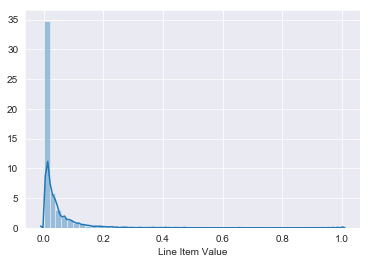

In [44]:
sns.distplot(df_obj['Line Item Value']);

In [45]:
# Apply Log + 1 transformation to normalize skewed data while accounting for zeros.
for col in nums.columns:
    df_obj[col] = np.log(df[col]+1)

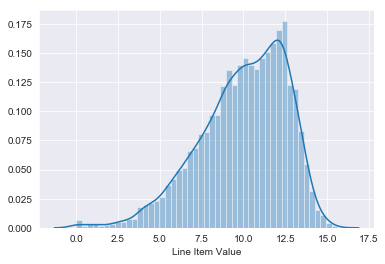

In [46]:
sns.distplot(df_obj['Line Item Value']);

# Benchmark Model Performance

In [ ]:
X_bench1 = df_obj.drop('Freight Cost (USD)',axis=1)
y_bench1 = df_obj['Freight Cost (USD)']

df_obj['y_bench_pred1'] = df_obj['Freight Cost (USD)'].mean()

In [ ]:
# Identify baseline scoring metrics for freight cost estimation
from sklearn import metrics

print('MAE:', metrics.mean_absolute_error(y_bench1, df_obj['y_bench_pred1']))
print('MSE:', metrics.mean_squared_error(y_bench1, df_obj['y_bench_pred1']))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_bench1, df_obj['y_bench_pred1'])))

In [ ]:
df_obj.drop('y_bench_pred1',axis=1,inplace=True)

In [ ]:
df_obj['Schedule v Actual'].mode()

In [ ]:
X_bench2 = df_obj.drop('Schedule v Actual',axis=1)
y_bench2 = df_obj['Schedule v Actual'].astype('category')

df_obj['y_bench_pred2'] = 0

In [ ]:
print(metrics.accuracy_score(y_bench2,df_obj['y_bench_pred2']))

In [ ]:
df_obj.drop('y_bench_pred2',axis=1,inplace=True)

In [ ]:
# Start modeling. (Establish pipeline for supervised models) then branch out into Deep Learning and LSTM's

# Begin LSTM Forecasting

In [ ]:
# Use LSTM to forecast freight costs per month 

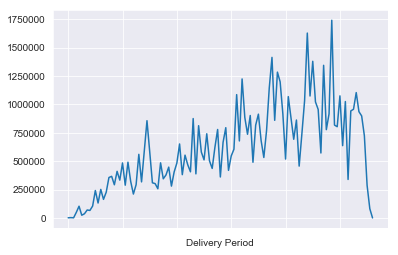

In [53]:
df.groupby(['Delivery Period'])['Freight Cost (USD)'].sum().plot();

In [52]:
fc_data = df.groupby(['Delivery Period'])['Freight Cost (USD)'].sum()

In [119]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# frame forecast sequence as supervised learning problem
def timeseries_to_supervised(data, lag=1):
    columns = [data.shift(i) for i in range(1, lag+1)]
    columns.append(data)
    df = pd.concat(columns, axis=1)
    df.fillna(0,inplace=True)
    return df

# create differenced series
def difference(data, interval=1):
    diff= list()
    for i in range(interval, len(data)):
        value = data[i] - data[i-interval]
        diff.append(value)
    return pd.Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# scale data
def scale(train, test):
    scaler = MinMaxScaler(feature_range=(-1,1))
    scaler = scaler.fit(train)
    # Scale Training Data
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # Scale Test data
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]
 
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(124, activation = 'relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model
 
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

In [108]:
# Transform data to be stationary
diff_values = difference(fc_data)

# Frame as supervised learning
supervised = timeseries_to_supervised(diff_values,1)
supervised_values = supervised.values

# Split to Train and Test sets
train, test = supervised_values[0:-25], supervised_values[-25:-1]

# Scale data
scaler, train_scaled, test_scaled = scale(train, test)

In [109]:
naive_pred = np.full((len(test),1), fc_data.mean())

In [111]:
from sklearn.metrics import mean_squared_error
# Establish Benchmark 

rmse = sqrt(mean_squared_error(fc_data.values[-25:-1], naive_pred))
print('Benchmark RMSE: %.3f' % rmse)

Benchmark RMSE: 486876.478


In [128]:
# fit LSTM network
lstm_model = fit_lstm(train_scaled, 1, 3000, 4)

# forecast training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled),1,1)
lstm_model.predict(train_reshaped, batch_size=1)

# Implement early stopping? Plot learning curve? Or remove Dense layer and use flat LSTM

KeyboardInterrupt: 

Month=1, Predicted=2687531.312137, Expected=1627755
Month=2, Predicted=1588358.968461, Expected=1073592
Month=3, Predicted=590389.489592, Expected=1379217
Month=4, Predicted=1108748.699601, Expected=1021683
Month=5, Predicted=1122336.815400, Expected=955120
Month=6, Predicted=812513.633221, Expected=571742
Month=7, Predicted=1994243.800863, Expected=1343793
Month=8, Predicted=959018.329366, Expected=777364
Month=9, Predicted=3920581.390938, Expected=916304
Month=10, Predicted=3029910.659329, Expected=1740715
Month=11, Predicted=647399.573789, Expected=817621
Month=12, Predicted=1859291.251516, Expected=803151
Month=13, Predicted=2393063.705789, Expected=1074761
Month=14, Predicted=859936.653999, Expected=636354
Month=15, Predicted=150626.600142, Expected=1024728
Month=16, Predicted=328250.939372, Expected=338572
Month=17, Predicted=2012917.828282, Expected=942156
Month=18, Predicted=1116823.600375, Expected=956871
Month=19, Predicted=1204200.345904, Expected=1103660
Month=20, Predicted

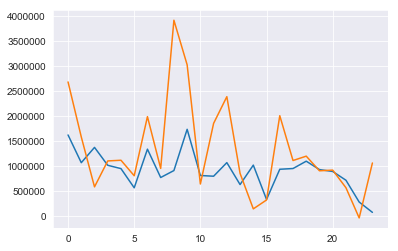

In [127]:
from math import sqrt
from matplotlib import pyplot
import numpy

# validatiion on test data
predictions = list()
for i in range(len(test_scaled)):
    # one step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i,-1]
    yhat = forecast_lstm(lstm_model,1,X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(fc_data.values, yhat, len(test_scaled)+1-i)
    # store forecast
    predictions.append(yhat)
    expected = fc_data.values[len(train) + i + 1]
    print('Month=%d, Predicted=%f, Expected=%i'% (i+1, yhat, expected))
    
rmse = sqrt(mean_squared_error(fc_data.values[-25:-1], predictions))
print('Test RMSE: %.3f' % rmse)

# plot observed vs forecasted
pyplot.plot(fc_data.values[-25:-1])
pyplot.plot(predictions)
pyplot.show()